## IMDB Graph extraction

This notebook is not part of the course but gives an illustration on how to extract the linked actor graph from a part of the IMDB database which can be found in the data directory.

The following code snipped will create the nodes and edge list of all actors acting within movies given a certain criteria within the sql query. 

In [1]:
# Lets clear all previous python imports and variables by resetting the python kernel.
%reset -f

%matplotlib nbagg

import matplotlib               # Matplotlib is the core package to plot publication grade images
import matplotlib.pyplot as plt # # Pyplot: a collection functions that make matplotlib work like MATLAB
import networkx as nx 
import math

import sqlite3
import os

teacher_dir = os.getenv('TEACHER_DIR')
dbpath = os.path.join(teacher_dir, 'JHS_data', 'imdb/imdb.db') # The path to the shared imdb database file
conn = sqlite3.connect(dbpath) # Refer to your own imdb sql file

c = conn.cursor()

c.execute('''
    SELECT n.name, t.title
    FROM cast_info ci
    INNER JOIN name n
    ON ci.person_id=n.id
    INNER JOIN title t
    ON ci.movie_id=t.id AND (ci.role_id='1' or ci.role_id='2' ) AND t.kind_id='1'
    INNER JOIN movie_info_idx mii
    ON ci.movie_id=mii.movie_id AND mii.info_type_id=101 AND CAST(mii.info AS float)>8
    INNER JOIN movie_info_idx mii2
    ON ci.movie_id=mii2.movie_id AND mii2.info_type_id=100
    WHERE ci.movie_id IN(
        SELECT t.id
        FROM title t
        INNER JOIN movie_info_idx mii
        ON mii.movie_id=t.id AND mii.info_type_id=100 AND cast(mii.info as int)>=900000
    )
''')

namemoviemap = {}   
movienamemap = {}   
nodes = []

for row in c.fetchall():
    name = row[0].encode("utf-8")
    movie = row[1].encode("utf-8")

    if name not in namemoviemap:
        namemoviemap[name] = []
    if movie not in namemoviemap[name]:
        namemoviemap[name].append(movie)

    if movie not in movienamemap:
        movienamemap[movie] = []
    if name not in movienamemap[movie]:
        movienamemap[movie].append(name)
    
nodes = list(movienamemap.keys())

edges = []
linkMap = {}
nrOfEdges = 0

for movie in nodes:                     # iterate over all actors (nodes)
   
    actors = movienamemap[movie]         # get all movies associated to the actor
    for actor in actors:                # for each movie we need to make a link to a co-actor
        linkedMovies = namemoviemap[actor] # get all actors acting in the movie
        for linkedMovie in linkedMovies: # for each co-actor we need to make a link
            if  movie == linkedMovie: # do nothing while the actor is the same as the co-actor
                continue
                
            # if both combination string keys are not in link map yet create new edge
            if movie+linkedMovie not in linkMap and linkedMovie+movie not in linkMap: 
                edge = (nodes.index(movie), nodes.index(linkedMovie), {'actors': [actor], 'weight': 1, 'id': nrOfEdges})
                edges.append(edge)
                linkMap[movie+linkedMovie] = edge # store EdgeId
                nrOfEdges += 1
            else:
                edge = linkMap[movie+linkedMovie] if movie+linkedMovie in linkMap else linkMap[linkedMovie+movie]
                if actor not in edge[2]['actors']:
                    edge[2]['actors'].append(actor)
                    edge[2]['weight'] += 1

You can use the following code cells to see what the querried graph looks like.

In [2]:
G=nx.Graph()
G.add_nodes_from([(idx, {'name':name})for idx, name in enumerate(nodes)])
G.add_edges_from(edges)

<IPython.core.display.Javascript object>


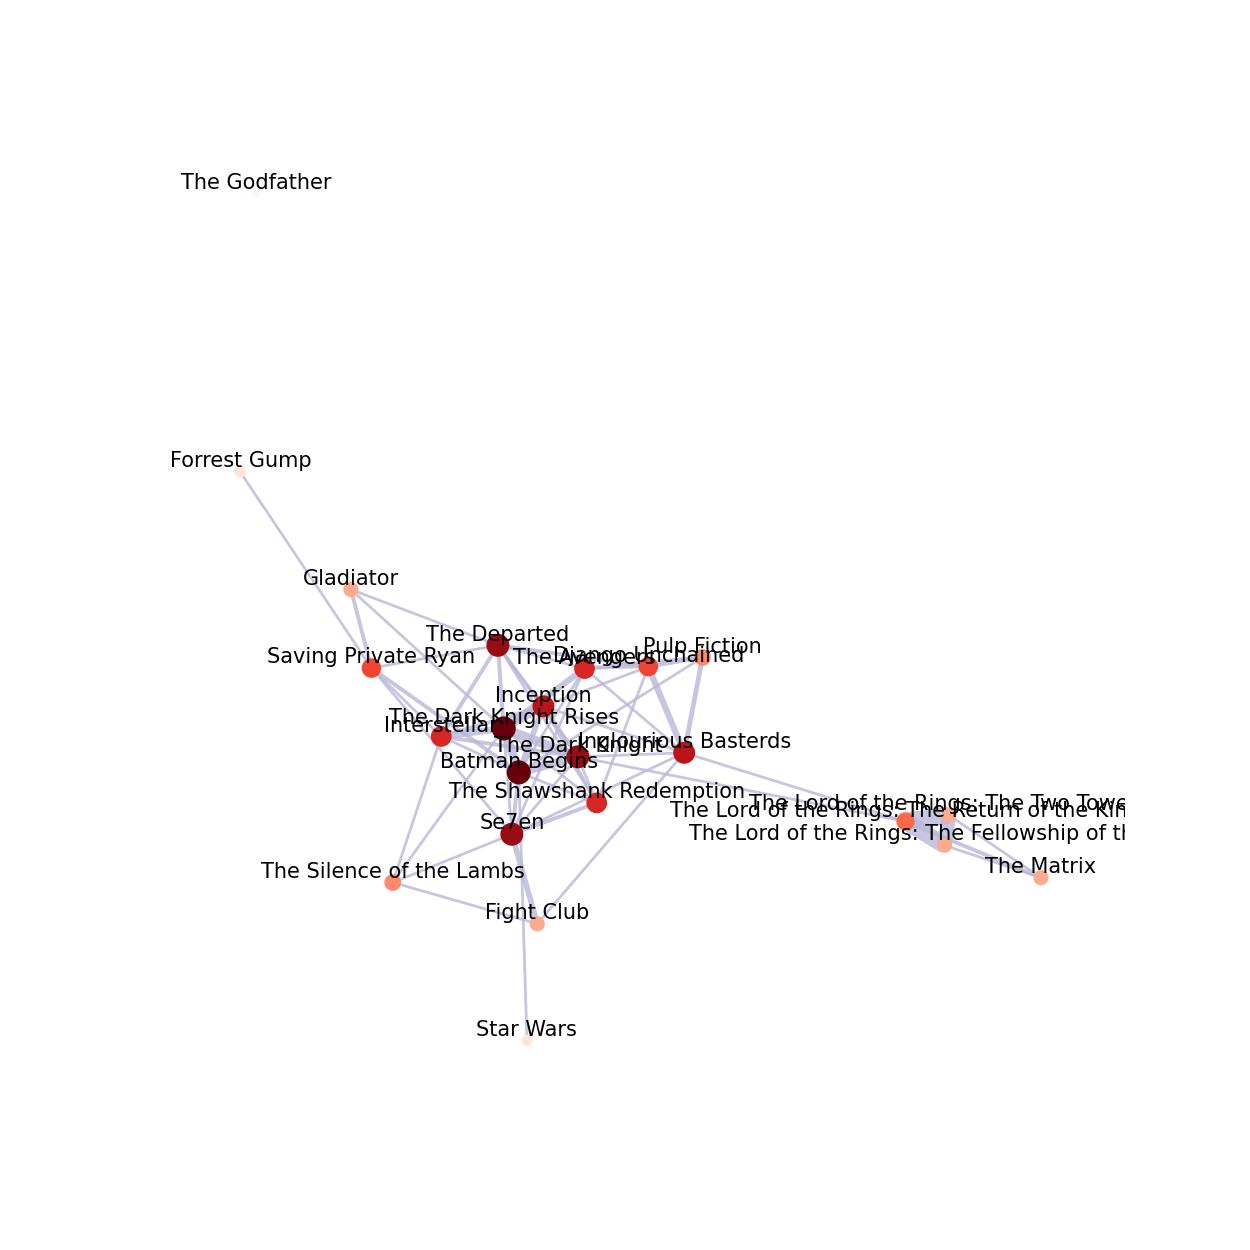

In [4]:
layoutFig = plt.figure(figsize=(10,10))

# A list for the size of every node in the graph based on their degree (the amount of connected neighbours)
# We add one or else nodes with no neighbours would have size 0
nodeSizes  = [15*(len(G[node[0]])+1) for node in G.nodes(data=True)] 

# A list for the color of every node in the graph based on their degree (the amount of connected neighbours)
nodeValuesColorMapping = nodeSizes

# A dictionary with key:nodeId and value:labelname to label each node in the visualisation
nodelabels     = {node[0]: node[1]['name'].decode('utf-8') for node in G.nodes(data=True)} 

edgeWeights = [edge[2]['weight'] for edge in G.edges(data=True)]
maxWeight = float(max(edgeWeights))
edgeWeights = [math.sqrt(x / maxWeight)*10 for x in edgeWeights] 

edgeLabels = {(edge[0], edge[1]) : edge[2]['id'] for edge in G.edges(data=True)}

subLayoutPositions = nx.spring_layout(G, k=0.5)

subLayoutLabelPos = {node:[pos[0],pos[1]+0.02] for (node,pos) in subLayoutPositions.items()}

nx.draw_networkx_nodes(G, 
         pos=subLayoutPositions,  
         node_size=nodeSizes,               # Give the node sizes
         node_color=nodeValuesColorMapping, # Give the values for the color mapping
         cmap=plt.cm.Reds,                  # PyPlot colormap called Reds (color map from light red to dark red)
    )

# Uncomment the following lines of code  to see the node labels
nx.draw_networkx_labels(G,
                       pos=subLayoutLabelPos,
                       labels=nodelabels
                       )

nx.draw_networkx_edges(G,
                       pos=subLayoutPositions,
                       width = edgeWeights,
                       edge_color=matplotlib.colors.rgb2hex(plt.cm.Purples(100)),
                      alpha=0.8
  )

plt.axis('off');